Team Members:
Arnas Juravicius - 18257305
Oisin McNamara - 18237398

The code executes without error

Sourses used to implement CNN:

https://www.kaggle.com/izabellaleroy/guide-for-beginners-pretrained-neural-network

https://www.kaggle.com/amolikvivian/classification-90-using-transfer-learning-eda

https://www.kaggle.com/drfrank/lego-transfer-cnn-classification

https://www.kaggle.com/aakash4235/lego-minifigures-with-efficencynet-94

https://www.kaggle.com/ihelon/lego-minifigures-tensorflow-tutorial

https://www.kaggle.com/arbazkhan971/lego-minifigures-classification-for-beginner

In [1]:
# We first need to unzip all the data required.
! unzip harry-potter.zip
! unzip jurassic-world.zip
! unzip marvel.zip
! unzip star-wars.zip
! unzip test.zip

Archive:  harry-potter.zip
   creating: harry-potter/0001/
  inflating: harry-potter/0001/001.jpg  
  inflating: harry-potter/0001/002.jpg  
  inflating: harry-potter/0001/003.jpg  
  inflating: harry-potter/0001/004.jpg  
  inflating: harry-potter/0001/005.jpg  
  inflating: harry-potter/0001/006.jpg  
  inflating: harry-potter/0001/007.jpg  
  inflating: harry-potter/0001/008.jpg  
  inflating: harry-potter/0001/009.jpg  
  inflating: harry-potter/0001/010.jpg  
  inflating: harry-potter/0001/011.jpg  
  inflating: harry-potter/0001/012.jpg  
  inflating: harry-potter/0001/013.jpg  
   creating: harry-potter/0002/
  inflating: harry-potter/0002/001.jpg  
  inflating: harry-potter/0002/002.jpg  
  inflating: harry-potter/0002/003.jpg  
  inflating: harry-potter/0002/004.jpg  
  inflating: harry-potter/0002/005.jpg  
  inflating: harry-potter/0002/006.jpg  
  inflating: harry-potter/0002/007.jpg  
  inflating: harry-potter/0002/008.jpg  
  inflating: harry-potter/0002/009.jpg  
  infla

In [2]:
# All the imports needed for the project
import matplotlib.pyplot as plt
import os
import cv2
import tensorflow as tf 
import pandas as pd
import numpy as np
from tensorflow.keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
import plotly.graph_objects as go
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.callbacks import EarlyStopping
import seaborn as sn

# Data Exploration

In [3]:
# First we explore the data in the index and metadata csv files
index_file = pd.read_csv('index.csv')
metadata = pd.read_csv('metadata.csv')
# We merge both csv files into one data frame called df which has all the data needed
df = pd.merge(index_file, metadata[['class_id','minifigure_name']], on='class_id')
df

,path,class_id,minifigure_name
0,marvel/0001/001.jpg,1,SPIDER-MAN
1,marvel/0001/002.jpg,1,SPIDER-MAN
2,marvel/0001/003.jpg,1,SPIDER-MAN
3,marvel/0001/004.jpg,1,SPIDER-MAN
4,marvel/0001/005.jpg,1,SPIDER-MAN
...,...,...,...
356,star-wars/0016/005.jpg,37,OBI-WAN KENOBI
357,star-wars/0016/006.jpg,37,OBI-WAN KENOBI
358,star-wars/0016/007.jpg,37,OBI-WAN KENOBI
359,star-wars/0016/008.jpg,37,OBI-WAN KENOBI


In [4]:
# Now we create a test date frame using the test csv file
test = pd.read_csv('test.csv')
# We merge the test data frame with the metadata as above
testDF = pd.merge(test, metadata[['class_id','minifigure_name']], on='class_id')
testDF

,path,class_id,minifigure_name
0,test/001.jpg,32,JANNAH
1,test/002.jpg,32,JANNAH
2,test/003.jpg,32,JANNAH
3,test/004.jpg,32,JANNAH
4,test/005.jpg,1,SPIDER-MAN
...,...,...,...
71,test/072.jpg,36,EMPEROR PALPATINE
72,test/073.jpg,36,EMPEROR PALPATINE
73,test/074.jpg,37,OBI-WAN KENOBI
74,test/075.jpg,37,OBI-WAN KENOBI


In [5]:
# We firstly explore the number of minifigure names that appear in the dataset
# This counts the total number of names that appear
df_minifigure_name = df['minifigure_name'].value_counts().to_frame().reset_index().rename(columns={'index':'minifigure_name','minifigure_name':'Count'})
# We then plot this data frame
fig = go.Figure(go.Bar(
    x=df_minifigure_name['minifigure_name'],y=df_minifigure_name['Count'],
    marker={'color': df_minifigure_name['Count'], 
    'colorscale': 'agsunset'},  
    text=df_minifigure_name['Count'],
    textposition = "outside",
))
fig.update_layout(title_text='Minifigure Count',xaxis_title="Minifigure Name",yaxis_title="Count",title_x=0.5)
fig.show()

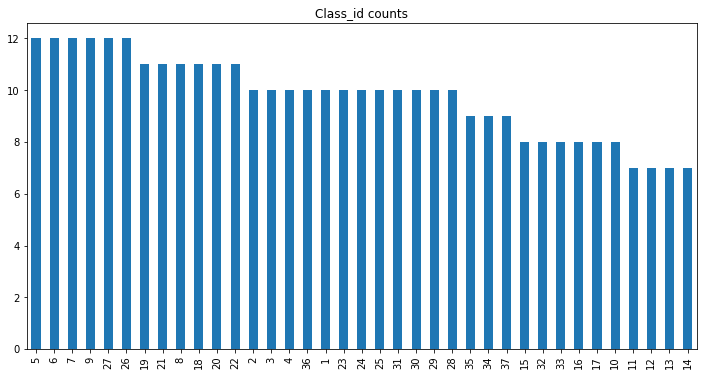

In [6]:
# We plot the number of class ids that appear aswell
df['class_id'].value_counts().plot(kind='bar', figsize=(12,6), title='Class_id counts')

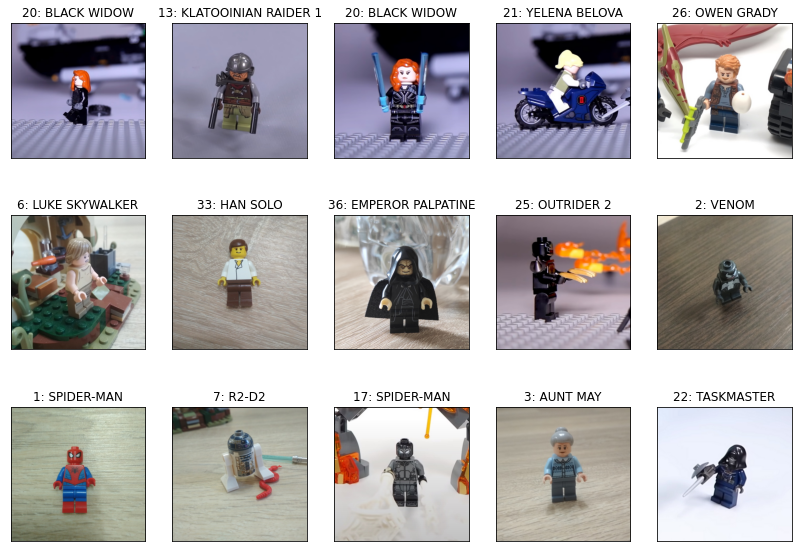

In [7]:
# The next step is the sample a random 15 images from the dataset and
# display them in a grid to get a feel for the images and what the look like
plt.figure(figsize=(14,10))
for i, j in enumerate(df.sample(15).iterrows(), 1):
    plt.subplot(3,5,i)
    # We read the image in here
    image = cv2.imread(os.path.join('.', j[1]['path']))
    # Transform the image to RGB
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    # Finally show the image
    plt.imshow(image)
    # Also print the class id and name out
    plt.title(f"{j[1]['class_id']}: {j[1]['minifigure_name']}")
    plt.xticks([])
    plt.yticks([])

In [8]:
# Now we start pre processing the data
df_train = df
df_test = testDF
# The data for the train is 361 in size and test it 76 in size
print(len(df_train))
print(len(df_test))

361
76


In [9]:
# This is for the data augmentation part used in the model
# Each epoch will genearte the image differently during run time
# This helps prevent the model from over fitting
datagen = ImageDataGenerator(horizontal_flip=True,vertical_flip=True,
                             rotation_range=20,zoom_range=0.2,
                            width_shift_range=0.2,height_shift_range=0.2,
                             shear_range=0.1,fill_mode="nearest")

In [10]:
# Training Data Preprocessing
# X_train takes the shape of the train data
X_train = np.zeros((df_train.shape[0], 128, 128, 3))
# We preprocesses every image in the train data
for i in range(df_train.shape[0]):
    # We read in the image firstly from the dataframe using the path
    image = cv2.imread('./' + df_train["path"].values[i])
    #Converting BGR to RGB 
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    #Resizing image to (128 x 128) to improve speed but lower image resolution
    image = cv2.resize(image, (128,128))
    #Normalizing pixel values to [0,1]
    X_train[i] = image / 255.0
# Create Y_train using the class ids
Y_train = np.array(df_train["class_id"])-1
Y_train = to_categorical(Y_train)
print(Y_train.shape)

(361, 37)


In [11]:
#Test Data Preprocessing
# Same applies as above
X_test = np.zeros((df_test.shape[0], 128, 128, 3))
for i in range(df_test.shape[0]):
    # Reading in the image
    image = cv2.imread('./' + df_test["path"].values[i])
    #Converting BGR to RGB 
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    #Resizing image to (512 x 512) 
    image = cv2.resize(image, (128,128))
    #Normalizing pixel values to [0,1]
    X_test[i] = image / 255.0
# Create Y_test using class ids
Y_test = np.array(df_test["class_id"])-1
Y_test = to_categorical(Y_test)
print(Y_test.shape)

(76, 37)


In [12]:
# We initialise the dense net 201 with the correct input shape of the data
# This is a pretrained model
# We get the weights from imagenet
# We also use average pooling
pretrained_model3 = tf.keras.applications.DenseNet201(input_shape=(128,128,3),
                                                      include_top=False,
                                                      weights='imagenet',
                                                      pooling='avg')
# This stops the layers from being trained so transfer learning can occur
pretrained_model3.trainable = False

74850304/74836368 [==============================] - 1s 0us/step


In [13]:
# Gets the number of unique classes
number_of_classes = len(df['class_id'].unique())
# Gets the inputs of pretrained model, the ones we defined ie 128x128x3
inputs3 = pretrained_model3.input
# Adds an activation layer
x3 = tf.keras.layers.Dense(128, activation='relu')(pretrained_model3.output)
# Adds softmax to output layer
outputs3 = tf.keras.layers.Dense(number_of_classes, activation='softmax')(x3)
# Creates the new model with all layers defined
model = tf.keras.Model(inputs=inputs3, outputs=outputs3)

In [14]:
# We compile the model using mse, Adam with a learning rate and accuracy for metrics
model.compile(loss='mse',
              optimizer=Adam(0.0001),
              metrics=['accuracy'])

In [15]:
# Prints a summary of model
print(model.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 134, 134, 3)  0          ['input_1[0][0]']                
                                                                                                  
 conv1/conv (Conv2D)            (None, 64, 64, 64)   9408        ['zero_padding2d[0][0]']         
                                                                                                  
 conv1/bn (BatchNormalization)  (None, 64, 64, 64)   256         ['conv1/conv[0][0]']         

In [16]:
# This earlystopping helps check for overfitting
# It stops the model if the accuracy doesn't improve after 3 epochs
early_stopping = EarlyStopping(monitor='accuracy', patience=10, min_delta=0.01, mode='auto')

In [17]:
# This if for transfer learning
# It stops the first 8 layers from being trained
for layer in model.layers[:-8]:
    layer.trainable=False
# Training can only occur after the 8 layer
for layer in model.layers[-8:]:
    layer.trainable=True

In [18]:
# Finally fit the model
# datagen.flow as mentioned above returns a random image for each epoch on the training set
# This involves rotation, shearing, flipping, etc
# This helps the model from overfitting as we were getting an accuracy of 100% before this step
# We give it 50 epochs and a batch size of 3
hist=model.fit(
    datagen.flow(X_train, Y_train, batch_size=16),
    epochs=40, 
    validation_data=(X_test, Y_test), 
    shuffle=True, 
    batch_size=3, 
    verbose=1,
    callbacks=[early_stopping]
)

Epoch 1/40
23/23 [==============================] - 51s 2s/step - loss: 0.0272 - accuracy: 0.0166 - val_loss: 0.0275 - val_accuracy: 0.0132
Epoch 2/40
23/23 [==============================] - 36s 2s/step - loss: 0.0268 - accuracy: 0.0388 - val_loss: 0.0271 - val_accuracy: 0.0263
Epoch 3/40
23/23 [==============================] - 36s 2s/step - loss: 0.0263 - accuracy: 0.0665 - val_loss: 0.0269 - val_accuracy: 0.0263
Epoch 4/40
23/23 [==============================] - 38s 2s/step - loss: 0.0260 - accuracy: 0.1163 - val_loss: 0.0266 - val_accuracy: 0.0658
Epoch 5/40
23/23 [==============================] - 39s 2s/step - loss: 0.0257 - accuracy: 0.1357 - val_loss: 0.0265 - val_accuracy: 0.0526
Epoch 6/40
23/23 [==============================] - 38s 2s/step - loss: 0.0256 - accuracy: 0.1717 - val_loss: 0.0263 - val_accuracy: 0.0526
Epoch 7/40
23/23 [==============================] - 37s 2s/step - loss: 0.0250 - accuracy: 0.2022 - val_loss: 0.0262 - val_accuracy: 0.0395
Epoch 8/40
23/23 [==

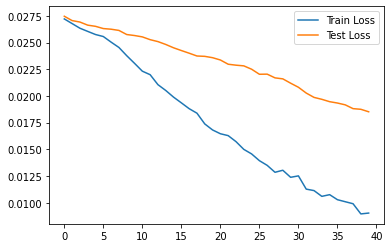

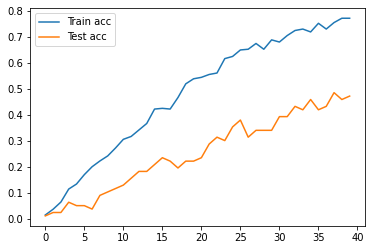

3/3 [==============================] - 6s 2s/step - loss: 0.0185 - accuracy: 0.4737
The accuracy is : % 47.36842215061188
The loss is : % 1.8514487892389297


In [19]:
# Here we plot the training vs the test accuracy and loss
# We believe that it is not overfitting or underfitting from the results
plt.plot(hist.history["loss"], label = "Train Loss")
plt.plot(hist.history["val_loss"], label = "Test Loss")
plt.legend()
plt.show()

plt.figure()
plt.plot(hist.history["accuracy"], label = "Train acc")
plt.plot(hist.history["val_accuracy"], label = "Test acc")
plt.legend()
plt.show()

# We evaulate the score of the model
# We get accuracy of around 50-60% and a loss of 1-2% which is pretty good
score = model.evaluate(X_test, Y_test,verbose=1)
print("The accuracy is : %" , score[1] * 100)
print("The loss is : %" , score[0] * 100)

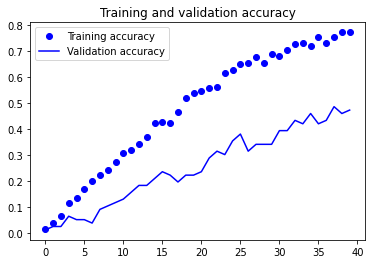

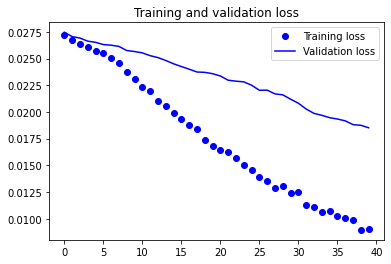

In [20]:
# This shows us that the model is slighting overftting since the validation loss is not decreasing as much as the training loss
# Although it is still decreasing and not increasing
accuracy = hist.history['accuracy']
val_accuracy = hist.history['val_accuracy']
loss = hist.history['loss']
val_loss = hist.history['val_loss']
epochs = range(len(accuracy))
plt.plot(epochs, accuracy, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [21]:
# Here we predict using the test set
y_pred = model.predict(X_test)
# Here we make np array froms the data
y_pred = np.argmax(y_pred, axis=1)
y_test = np.argmax(Y_test, axis=1)
# We print precision, recall and the f1-score for each image in the test set
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.50      0.67         2
           1       0.00      0.00      0.00         2
           2       0.00      0.00      0.00         2
           3       0.00      0.00      0.00         2
           4       0.50      1.00      0.67         2
           5       0.67      1.00      0.80         2
           6       0.50      1.00      0.67         2
           7       0.50      0.50      0.50         2
           8       1.00      1.00      1.00         2
           9       0.50      1.00      0.67         2
          10       0.00      0.00      0.00         1
          11       0.25      1.00      0.40         1
          12       0.00      0.00      0.00         1
          13       0.00      0.00      0.00         1
          14       0.50      1.00      0.67         1
          15       1.00      1.00      1.00         1
          16       0.00      0.00      0.00         1
          17       0.00    

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



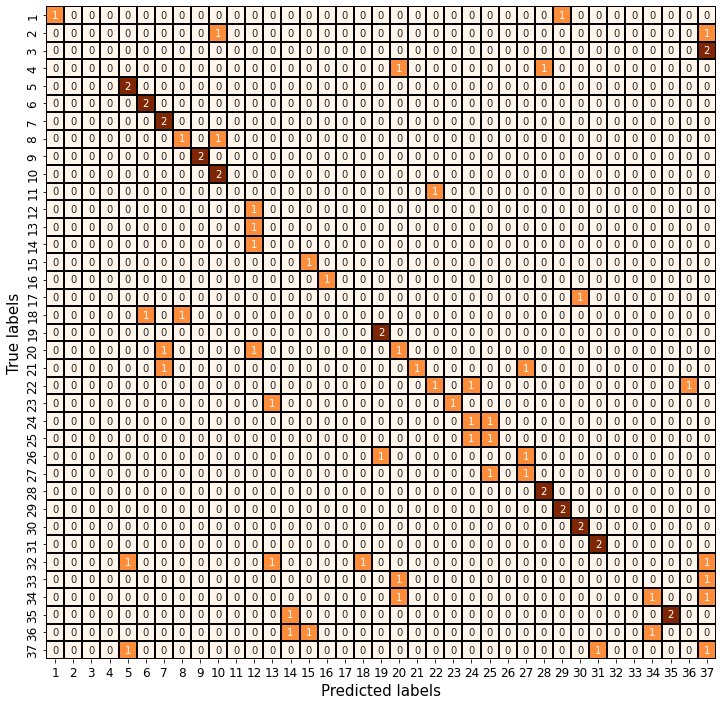

In [22]:
# Load metadata to get classes people-friendly names
labels = df["class_id"].unique().tolist()

# Calculate confusion matrix
cm = confusion_matrix(y_test, y_pred)
df_confusion_matrix = pd.DataFrame(cm, index=labels, columns=labels)

# Show confusion matrix
plt.figure(figsize=(12, 12))
sn.heatmap(df_confusion_matrix, annot=True, cbar=False, cmap="Oranges", linewidths=1, linecolor="black")
plt.xlabel("Predicted labels", fontsize=15)
plt.xticks(fontsize=12)
plt.ylabel("True labels", fontsize=15)
plt.yticks(fontsize=12)
plt.show()

In [23]:
# Here we start testing our model using 20 random images from the test data frame
test = testDF.sample(20)
test

,path,class_id,minifigure_name
74,test/075.jpg,37,OBI-WAN KENOBI
35,test/036.jpg,21,YELENA BELOVA
41,test/042.jpg,24,OUTRIDER 1
68,test/069.jpg,35,ANAKIN SKYWALKER
60,test/061.jpg,12,CARA DUNE
75,test/076.jpg,37,OBI-WAN KENOBI
2,test/003.jpg,32,JANNAH
69,test/070.jpg,35,ANAKIN SKYWALKER
47,test/048.jpg,29,IRON MAN MK 5
52,test/053.jpg,31,IRON MAN MK 50


Class: 37 Predicted Name of Minifigure: OBI-WAN KENOBI


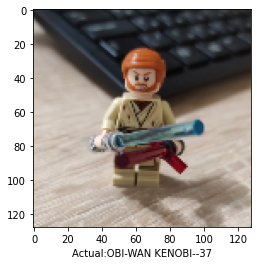

Class: 27 Predicted Name of Minifigure: TRACKER TRAQUEUR RASTREADOR


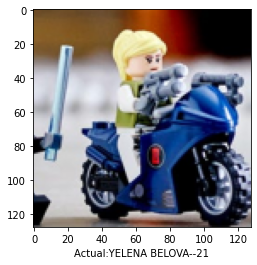

Class: 24 Predicted Name of Minifigure: OUTRIDER 1


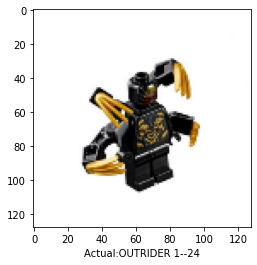

Class: 35 Predicted Name of Minifigure: ANAKIN SKYWALKER


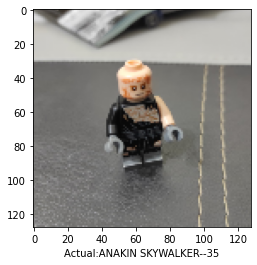

Class: 12 Predicted Name of Minifigure: CARA DUNE


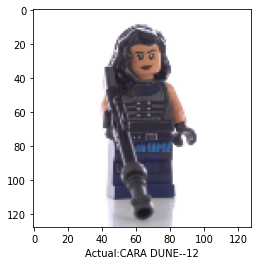

Class: 5 Predicted Name of Minifigure: YODA


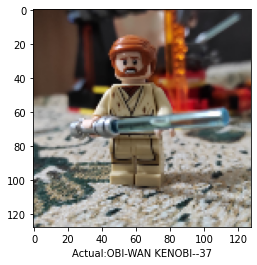

Class: 5 Predicted Name of Minifigure: YODA


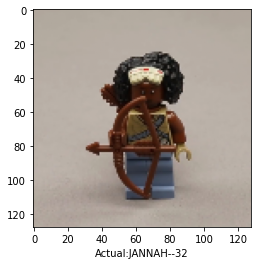

Class: 35 Predicted Name of Minifigure: ANAKIN SKYWALKER


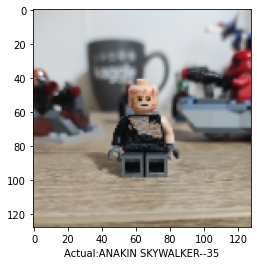

Class: 29 Predicted Name of Minifigure: IRON MAN MK 5


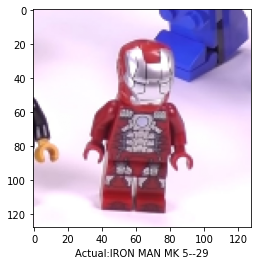

Class: 31 Predicted Name of Minifigure: IRON MAN MK 50


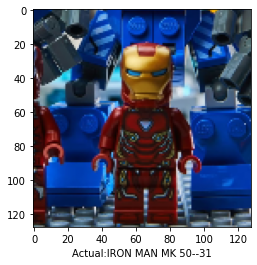

Class: 13 Predicted Name of Minifigure: KLATOOINIAN RAIDER 1


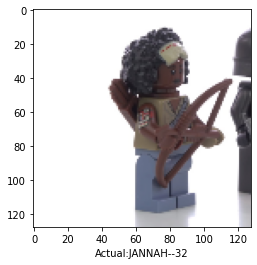

Class: 27 Predicted Name of Minifigure: TRACKER TRAQUEUR RASTREADOR


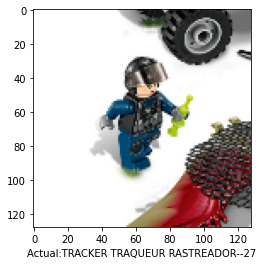

Class: 6 Predicted Name of Minifigure: LUKE SKYWALKER


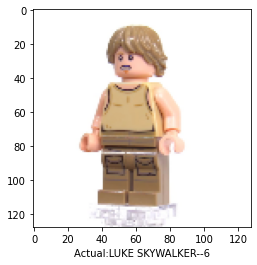

Class: 22 Predicted Name of Minifigure: TASKMASTER


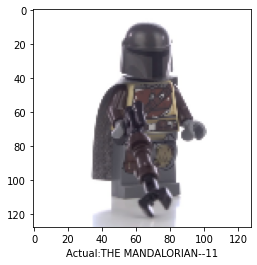

Class: 7 Predicted Name of Minifigure: R2-D2


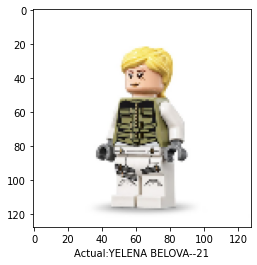

Class: 31 Predicted Name of Minifigure: IRON MAN MK 50


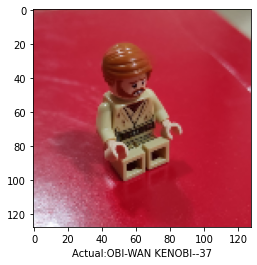

Class: 23 Predicted Name of Minifigure: CAPTAIN AMERICA


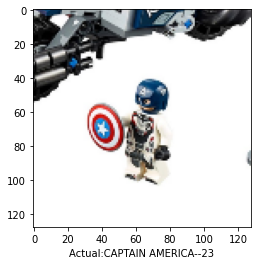

Class: 29 Predicted Name of Minifigure: IRON MAN MK 5


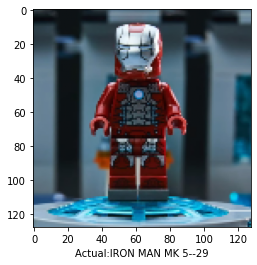

Class: 30 Predicted Name of Minifigure: IRON MAN MK 41


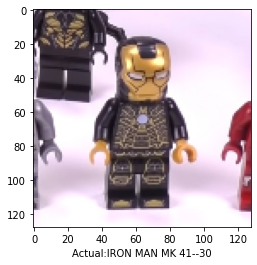

Class: 37 Predicted Name of Minifigure: OBI-WAN KENOBI


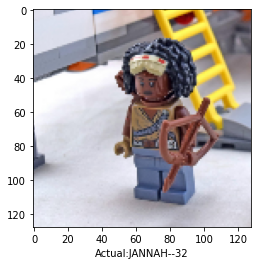

In [24]:
# Goes through the 20 random images
for i in range(20):
    # Reads in the image using the path from the test data frame
    image = cv2.imread('./'+test['path'].values[i])
    # Resizes image to correct size
    image = cv2.resize(image, dsize=(128,128))
    # Corercts the colour and normalizes it
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)/255
    # Shows the image
    plt.imshow(image)
    # Print out the actual name and class id of the image
    plt.xlabel('Actual:'+test['minifigure_name'].values[i]+'--'+str(test['class_id'].values[i]))
    # Reshgape into an np array
    image = np.reshape(image, (1, 128, 128, 3))
    # Predict that image using our model
    ans = model.predict(image).argmax()
    # We are not sure why but we need to add 1
    ans = ans+1
    # Get the predicted name and class id of the image that the model predicted
    minifigure = df["minifigure_name"][df["class_id"] == ans].iloc[0]
    # Finally print out the answer above the image
    print("Class:", str(ans)+ " Predicted Name of Minifigure:",minifigure)
    plt.show()